In [2]:
import csv
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [2]:
low_file_name = "MartinAcresLow_3500.MartinAcres.csv"
low_dict = {}
with open(low_file_name) as low_csv:
    csv_reader = csv.reader(low_csv, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            print(f'Column names are {", ".join(row)}')
            line_count += 1
        else:
            low_dict[row[0]] = list(map(lambda x: float(x), row[1:]))
            line_count += 1
high_file_name = "MartinAcresHigh_3500.MartinAcres.csv"
high_dict = {}
with open(high_file_name) as high_csv:
    csv_reader = csv.reader(high_csv, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            line_count += 1
        else:
            high_dict[row[0]] = list(map(lambda x: float(x), row[1:]))
            line_count += 1

Column names are ID, TxLat, TxLon, RxLat, RxLon, h_tx__meter, h_rx__meter, f__mhz, d__km, L_meas__db, L_fs__db, L_excess__db


In [3]:
low_dict['46']

[39.99476239,
 -105.2621935,
 39.99472841,
 -105.2594444,
 8.37,
 3.0,
 3500.0,
 0.234806158,
 103.632553,
 90.75552789,
 12.87702511]

In [4]:
## get Digital Terrain Model
dataset_terrain = rasterio.open("MartinAcres.dtm.tif")
## get Digital Surface Model
dataset_surface = rasterio.open("MartinAcres.dsm.tif")

In [5]:
band1_terrain = dataset_terrain.read(1)
band1_surface = dataset_surface.read(1)

In [6]:
print(dataset_terrain.bounds)
print(dataset_surface.bounds)

BoundingBox(left=475499.11, bottom=4424999.32, right=480000.11, top=4428000.32)
BoundingBox(left=475500.0, bottom=4425000.0, right=480001.0, top=4428000.0)


In [3]:
# BoundingBox(left=476384.0, bottom=4427929.0, right=477840.0, top=4429010.0)
# BoundingBox(left=476384.0, bottom=4427929.0, right=477840.0, top=4429010.0)

left = dataset_terrain.bounds[0]
top = dataset_terrain.bounds[3]
print(left, top)
coord_tl = (40.0018349,-105.2870386) ## calculated using coord system ESPG:32613 WGS 84/ UTM zone 13N
lat_deg = 111319.49 ## fixed, dont change (or use 111000)
long_deg = 85263.24 ## change to 93000


## get_elev takes a lat, long coordinates, and digital elevation model 
##  and returns a row, col pair based on the given model
def get_elev(lat, long, model):
    lat_dif = coord_tl[0] - lat
    long_dif = long - coord_tl[1]
    vert_dif_m = lat_dif * lat_deg
    horz_dif_m = long_dif * long_deg
    row, col = model.index(left + horz_dif_m, top - vert_dif_m)
    return (row, col)

## takes a lat, long coordinate pair
##  and returns a meters based coordinate pair
def convert_gps_to_meters(lat, long):
    lat_dif = coord_tl[0] - lat
    long_dif = long - coord_tl[1]
    vert_dif_m = lat_dif * lat_deg
    horz_dif_m = long_dif * long_deg
    return (top - vert_dif_m, left + horz_dif_m)


def convert_meters_to_gps(m_vert, m_horz):
    vert_dif_m = top - m_vert
    horz_dif_m = m_horz - left
    lat_dif = vert_dif_m / lat_deg
    long_dif = horz_dif_m / long_deg
    return (coord_tl[0] - lat_dif, coord_tl[1] + long_dif)

print(convert_gps_to_meters(coord_tl[0], coord_tl[1]))

NameError: name 'dataset_terrain' is not defined

In [10]:
tx_loc = (39.991772,-105.274513)

t_r, t_c = get_elev(tx_loc[0], tx_loc[1], dataset_terrain)
print(t_r, t_c)

tx_elev = band1_terrain[t_r][t_c]
print(tx_elev) ## should be about 1780

1120 1067
1778.4


In [8]:
dataset_terrain.transform

Affine(1.0, 0.0, 475499.11,
       0.0, -1.0, 4428000.32)

In [9]:
dataset_surface.transform

Affine(1.0, 0.0, 475500.0,
       0.0, -1.0, 4428000.0)

In [9]:
rx_loc = (39.98699011,-105.2473168) ## '986' on high measurements

r_r, r_c = get_elev(rx_loc[0], rx_loc[1], dataset_terrain)
print(r_r, r_c)

rx_elev = band1_terrain[r_r][r_c]
print(rx_elev) ## should be about 1646

1652 3386
1647.024


In [10]:
rx_loc = (39.99514053,-105.2589212) ## '61' on high measurements

r_r, r_c = get_elev(rx_loc[0], rx_loc[1], dataset_terrain)
print(r_r, r_c)

rx_elev = band1_terrain[r_r][r_c]
print(rx_elev) ## should be about 1646

745 2397
1643.6812


In [11]:
rx_loc = (39.99514053,-105.2589212) ## '61' on high measurements
## on the tranform webpage gives you 477896.98, 4427249.96
r_r, r_c = dataset_terrain.index(477896.98, 4427249.96)
print(r_r, r_c)
rx_elev = band1_terrain[r_r][r_c]
print(rx_elev) ## should be about 1646

750 2397
1643.8667


In [12]:
## get_elev_dif takes TX location, TX antenna height, RX location, and RX antenna height
##  returns the elevation difference of the antennas (based on the digital terrain model)

def get_elev_dif(tx, tx_height, rx, rx_height):
    tx_row, tx_col = get_elev(tx[0], tx[1], dataset_terrain)
    tx_elev = band1_terrain[tx_row][tx_col]
    rx_row, rx_col = get_elev(rx[0], rx[1], dataset_terrain)
    rx_elev = band1_terrain[rx_row][rx_col]
    return (tx_elev + tx_height) - (rx_elev + rx_height)

In [13]:
tx_e = 1780
rx_e = 1646
gm_toa = ((tx_e + high_dict['986'][4]) - (rx_e + high_dict['986'][5])) / (high_dict['986'][7] *1000)
gm_elev_deg = np.arctan(gm_toa)*360/(np.pi*2)
print("google maps says RX elevation angle is {:.2f}".format(gm_elev_deg))

t_r, t_c = get_elev(high_dict['986'][0], high_dict['986'][1], dataset_terrain)
tx_elev = band1_terrain[t_r][t_c]
r_r, r_c = get_elev(high_dict['986'][2], high_dict['986'][3], dataset_terrain)
rx_elev = band1_terrain[r_r][r_c]
tx_e = tx_elev
rx_e = rx_elev
toa = ((tx_e + high_dict['986'][4]) - (rx_e + high_dict['986'][5])) / (high_dict['986'][7] *1000)
elev_deg = np.arctan(toa)*360/(np.pi*2)
print("digital terrain map says RX elevation angle is {:.2f}".format(elev_deg))

google maps says RX elevation angle is 3.58
digital terrain map says RX elevation angle is 3.52


In [14]:
## '61' 39.99514053,-105.2589212
tx_e = 1780
rx_e = 1646
gm_toa = ((tx_e + high_dict['61'][4]) - (rx_e + high_dict['61'][5])) / (high_dict['61'][7] *1000)
gm_elev_deg = np.arctan(gm_toa)*360/(np.pi*2)
print("google maps says RX elevation angle is {:.2f}".format(gm_elev_deg))

t_r, t_c = get_elev(high_dict['61'][0], high_dict['61'][1], dataset_terrain)
tx_elev = band1_terrain[t_r][t_c]
r_r, r_c = get_elev(high_dict['61'][2], high_dict['61'][3], dataset_terrain)
rx_elev = band1_terrain[r_r][r_c]
tx_e = tx_elev
rx_e = rx_elev
toa = ((tx_e + high_dict['61'][4]) - (rx_e + high_dict['61'][5])) / (high_dict['61'][7] *1000)
elev_deg = np.arctan(toa)*360/(np.pi*2)
print("digital terrain map says RX elevation angle is {:.2f}".format(elev_deg))

google maps says RX elevation angle is 6.15
digital terrain map says RX elevation angle is 6.18


In [15]:
def table_print(pl, ea, cl):
    print("path length (m) \t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}".format(min(pl), max(pl), np.mean(pl), np.std(pl)))
    print("RX angle (deg)  \t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}".format(min(ea), max(ea), np.mean(ea), np.std(ea)))
    print("Clutter loss (dB) \t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}".format(min(cl), max(cl), np.mean(cl), np.std(cl)))

In [16]:
## TxLat, TxLon, RxLat, RxLon, h_tx__meter, 
##  h_rx__meter, f__mhz, d__km, L_meas__db, L_fs__db, 
##  L_excess__db, elev_dif
for key in low_dict.keys():
    elev_dif = get_elev_dif( (low_dict[key][0],low_dict[key][1]), low_dict[key][4], 
                             (low_dict[key][2],low_dict[key][3]), low_dict[key][5])
    low_dict[key].append(elev_dif)
for key in high_dict.keys():
    elev_dif = get_elev_dif( (high_dict[key][0],high_dict[key][1]), high_dict[key][4], 
                             (high_dict[key][2],high_dict[key][3]), high_dict[key][5])
    high_dict[key].append(elev_dif)

In [17]:
temp_dict = low_dict
low_path_length = []
low_elevation_angle = []
low_clutter_loss = []
for key in temp_dict.keys():
    toa = temp_dict[key][11] / (temp_dict[key][7]*1000)
    low_elevation_angle.append(np.arctan(toa)*360/(np.pi*2))
    low_path_length.append(np.sqrt(np.power(temp_dict[key][11],2) + np.power(temp_dict[key][7]*1000,2)))
    low_clutter_loss.append(temp_dict[key][10])

## Table 1, Low TX summary stats

In [18]:
table_print(low_path_length, low_elevation_angle, low_clutter_loss)

path length (m) 	202.63	2010.12	1164.93	498.65
RX angle (deg)  	0.21	3.25	1.09	0.74
Clutter loss (dB) 	-1.07	39.66	29.36	5.07


![alt text](./images/table1.PNG "Table 1")

In [19]:
temp_dict = high_dict
high_path_length = []
high_elevation_angle = []
high_clutter_loss = []
for key in temp_dict.keys():
    toa = temp_dict[key][12] / (temp_dict[key][7]*1000)
    high_elevation_angle.append(np.arctan(toa)*360/(np.pi*2))
    high_path_length.append(np.sqrt(np.power(temp_dict[key][12],2) + np.power(temp_dict[key][7]*1000,2)))
    high_clutter_loss.append(temp_dict[key][11])

## Table 2, High TX summary stats

In [20]:
table_print(high_path_length, high_elevation_angle, high_clutter_loss)

path length (m) 	1318.61	2883.89	2119.00	436.28
RX angle (deg)  	2.99	6.41	4.31	0.96
Clutter loss (dB) 	1.67	33.83	22.61	5.07


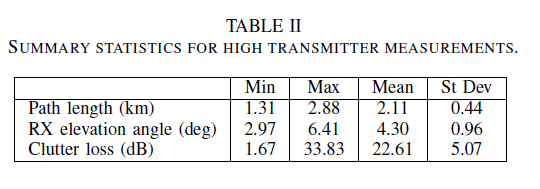![alt text](./images/table2.PNG "Table 2")

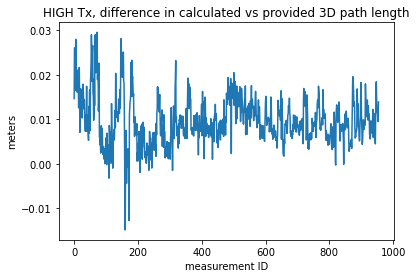

In [21]:
my_pl_a = np.array(high_path_length)
threed_col = []
for key in high_dict.keys():
    threed_col.append(high_dict[key][8]*1000)
data_pl_a = np.array(threed_col)
dif_a = my_pl_a - data_pl_a
xx = np.linspace(0,len(dif_a),len(dif_a))
plt.rcParams["figure.figsize"] = (15,8)
plt.title("HIGH Tx, difference in calculated vs provided 3D path length")
plt.xlabel("measurement ID")
plt.ylabel("meters")
plt.plot(xx, dif_a)
plt.show()

In [22]:
martin_acres = plt.imread('./images/martin_acres_zoom.png')
## for map_lil_bigger.png
long_min = -105.2751
long_max = -105.2405
lat_min = 39.9838
lat_max = 40.0009

BBox = (long_min,  long_max,      
         lat_min,   lat_max)

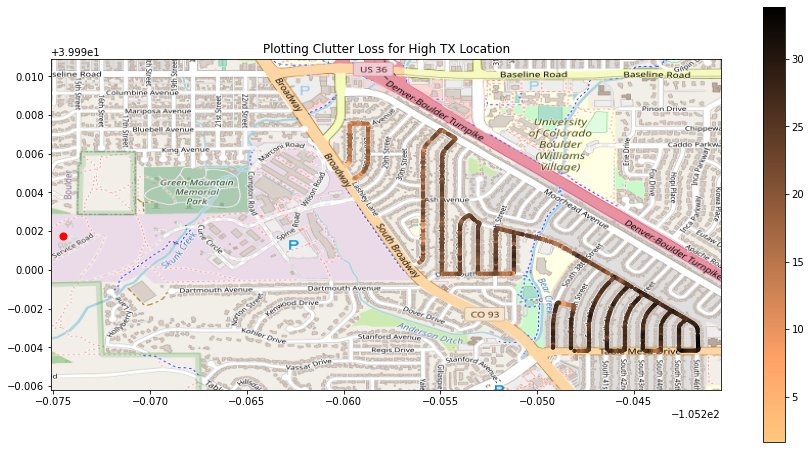

In [23]:
high_long = []
high_lat = []
high_excess_loss = []
for key in high_dict.keys():
    high_long.append(high_dict[key][3])
    high_lat.append(high_dict[key][2])
    high_excess_loss.append(high_dict[key][11])


plt.rcParams["figure.figsize"] = (15,8)
ex2 = plt.scatter(high_dict['102'][1],high_dict['102'][0], zorder=2, alpha=1.0, c='r', s=50)
ex1 = plt.scatter(high_long, high_lat, zorder=1, c=high_excess_loss, cmap='copper_r', alpha= 1.0, s=11)

plt.colorbar(ex1)
plt.title('Plotting Clutter Loss for High TX Location')
plt.xlim(BBox[0],BBox[1])
plt.ylim(BBox[2],BBox[3])
plt.imshow(martin_acres, zorder=0, extent = BBox, aspect= 'equal')
plt.show()

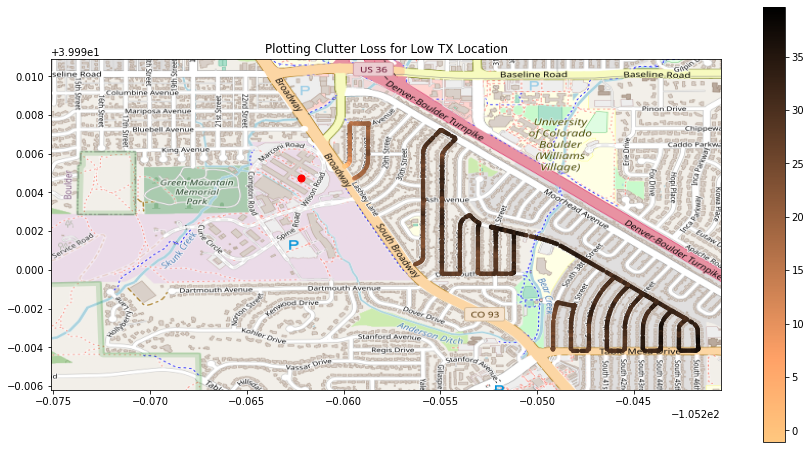

In [24]:
low_long = []
low_lat = []
low_excess_loss = []
for key in low_dict.keys():
    low_long.append(low_dict[key][3])
    low_lat.append(low_dict[key][2])
    low_excess_loss.append(low_dict[key][10])


plt.rcParams["figure.figsize"] = (15,8)
ex2 = plt.scatter(low_dict['102'][1],low_dict['102'][0], zorder=2, alpha=1.0, c='r', s=50)
ex1 = plt.scatter(low_long, low_lat, zorder=1, c=low_excess_loss, cmap='copper_r', alpha= 1.0, s=12)

plt.colorbar(ex1)
plt.title('Plotting Clutter Loss for Low TX Location')
plt.xlim(BBox[0],BBox[1])
plt.ylim(BBox[2],BBox[3])
plt.imshow(martin_acres, zorder=0, extent = BBox, aspect= 'equal')
plt.show()

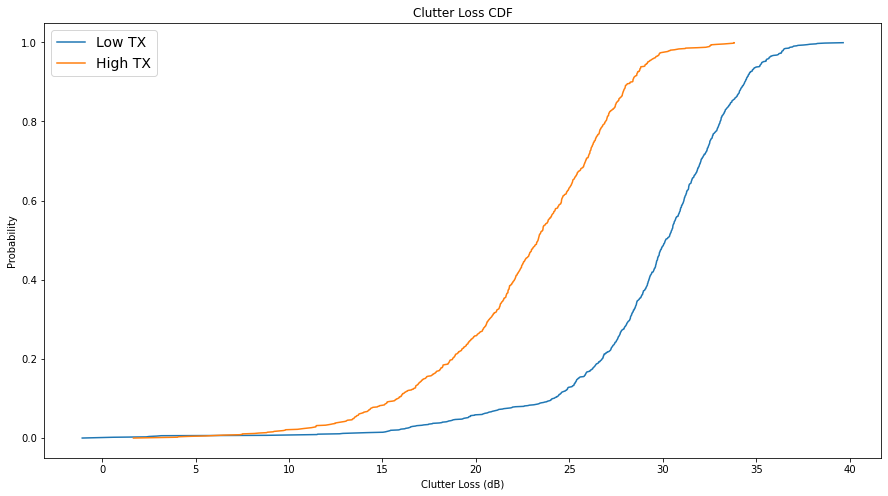

In [25]:
low_N = len(low_excess_loss)
low_excess_loss = np.array(low_excess_loss)
low_x = np.sort(low_excess_loss)
low_y = np.arange(low_N) / float(low_N)
plt.plot(low_x, low_y, label='Low TX')

high_N = len(high_excess_loss)
high_excess_loss = np.array(high_excess_loss)
high_x = np.sort(high_excess_loss)
high_y = np.arange(high_N) / float(high_N)
plt.plot(high_x, high_y, label='High TX')

plt.xlabel('Clutter Loss (dB)')
plt.ylabel('Probability')
plt.title('Clutter Loss CDF')
  

plt.legend(fontsize=14)
plt.show()


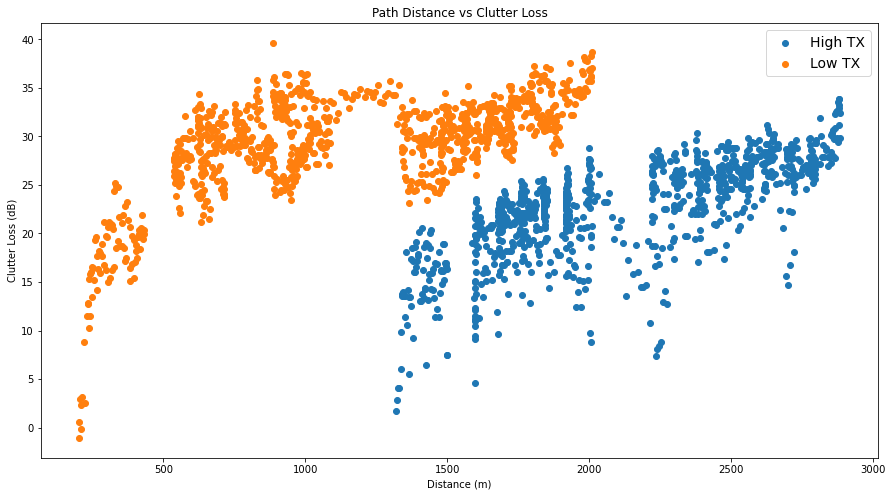

In [26]:
plt.scatter(high_path_length, high_clutter_loss, label='High TX')
plt.scatter(low_path_length, low_clutter_loss, label='Low TX')

plt.xlabel('Distance (m)')
plt.ylabel('Clutter Loss (dB)')
plt.title('Path Distance vs Clutter Loss')
  

plt.legend(fontsize=14)
plt.show()

### find clutter statistics of Martin Acres

In [27]:
ma_lat_min = 42
ma_lat_max = 38
ma_long_min = -100
ma_long_max = -110
for key in high_dict.keys():
    t_long = high_dict[key][3]
    t_lat = high_dict[key][2]
    if t_long > ma_long_max:
        ma_long_max = t_long
    if t_long < ma_long_min:
        ma_long_min = t_long
    if t_lat > ma_lat_max:
        ma_lat_max = t_lat
    if t_lat < ma_lat_min:
        ma_lat_min = t_lat
        
martin_acres_bbox = (ma_long_min,  ma_long_max,      
                     ma_lat_min,   ma_lat_max)

# 39.9961, -105.258
# 39.9858, -105.2412
martin_acres_bbox = (-105.258,  -105.2412,      
                     39.9858,   39.9961)
print(martin_acres_bbox)

ma_width_meters = (martin_acres_bbox[1] - martin_acres_bbox[0]) * long_deg
ma_height_meters = (martin_acres_bbox[3] - martin_acres_bbox[2]) * lat_deg
print(ma_width_meters, ma_height_meters)

(-105.258, -105.2412, 39.9858, 39.9961)
1432.4224319990851 1146.5907470000961


In [28]:
step_m = 1
width_samps = ma_width_meters//step_m 
height_samps = ma_height_meters//step_m
print("{} meter step, results in {} samples".format(step_m, width_samps * height_samps))
ma_long_step = (martin_acres_bbox[1] - martin_acres_bbox[0]) / width_samps
ma_lat_step = (martin_acres_bbox[3] - martin_acres_bbox[2]) / height_samps
print("longitude step = {}".format(ma_long_step))
print("latitude step = {}".format(ma_lat_step))

1 meter step, results in 1641072.0 samples
longitude step = 1.17318435754115e-05
latitude step = 8.987783595114192e-06


In [29]:
ma_longs = np.linspace(martin_acres_bbox[0], martin_acres_bbox[1], int(width_samps))
ma_lats = np.linspace(martin_acres_bbox[2], martin_acres_bbox[3], int(height_samps))
print("actual long step = {}\nactual lat step = {}".format(ma_longs[1] - ma_longs[0], ma_lats[1] - ma_lats[0]))

actual long step = 1.1740041927055245e-05
actual lat step = 8.995633187680596e-06


In [30]:
clutter_heights_ls = []
print("to complete {}".format(len(ma_longs)))
long_count = 0
for long_i in ma_longs:
    print("\rcount {}".format(long_count), end='')
    long_count += 1
    for lat_i in ma_lats:
        t_r, t_c = get_elev(lat_i, long_i, dataset_terrain)
        terrain_elev = band1_terrain[t_r][t_c]
        s_r, s_c = get_elev(lat_i, long_i, dataset_surface)
        surface_elev = band1_surface[s_r][s_c]
        elev_dif = surface_elev - terrain_elev
        if elev_dif >= 2:
            clutter_heights_ls.append(elev_dif)
        # print("{} - {} = {}".format(surface_elev, terrain_elev, surface_elev-terrain_elev))
print()
print("{} samples with clutter".format(len(clutter_heights_ls)))

to complete 1432
count 1431
887877 samples with clutter


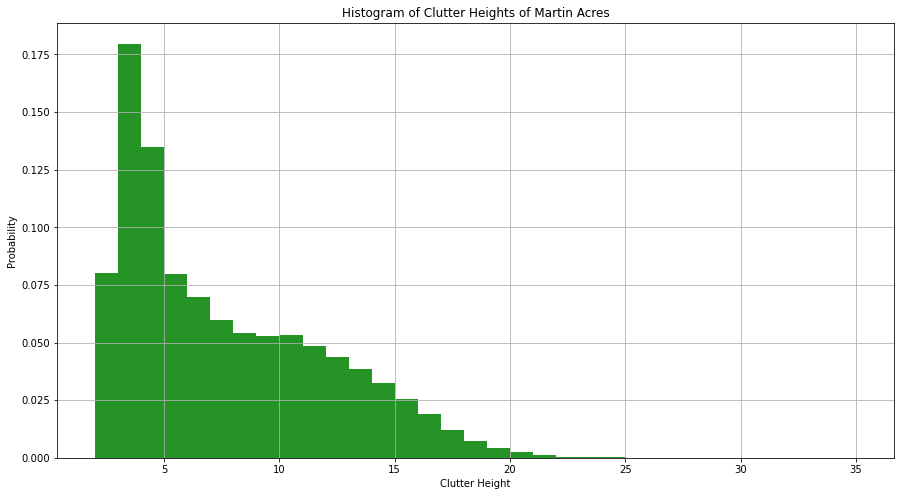

In [31]:
# the histogram of the data
n, bins, patches = plt.hist(clutter_heights_ls, np.linspace(2,35,34), density=True, facecolor='g', alpha=.85)


plt.xlabel('Clutter Height')
plt.ylabel('Probability')
plt.title('Histogram of Clutter Heights of Martin Acres')
plt.grid(True)
plt.show()

In [32]:
bway_n = (39.99741,-105.26173)
bway_mid = (39.98933,-105.25584)
bway_s = (39.98587,-105.25018)

def m_intersect(tx, rx, line_start, line_end):
    tx_m = convert_gps_to_meters(tx[0], tx[1]) ## return (vertical, horizontal) or (y,x)
    rx_m = convert_gps_to_meters(rx[0], rx[1])
    line_s_m = convert_gps_to_meters(line_start[0], line_start[1])
    line_e_m = convert_gps_to_meters(line_end[0], line_end[1])
    
    rise1 = tx_m[0] - rx_m[0]
    run1 = tx_m[1] - rx_m[1]
    m1 = rise1 / run1
    
    rise2 = line_s_m[0] - line_e_m[0]
    run2 = line_s_m[1] - line_e_m[1]
    m2 = rise2 / run2
    
    ## x and y are the intersection point (in meters)
    ## x = (m1*b - a - m2*d + c) / (m1 - m2)
    x = (m1*tx_m[1] - tx_m[0] - m2*line_s_m[1] + line_s_m[0]) / (m1 - m2)
    y = m1*(x-tx_m[1]) + tx_m[0]
    # print(m1, m2, x, y)
    dist_from_rx = np.sqrt(np.power(x - rx_m[1], 2) + np.power(y - rx_m[0] , 2))
    # print(dist_from_rx)
    return dist_from_rx

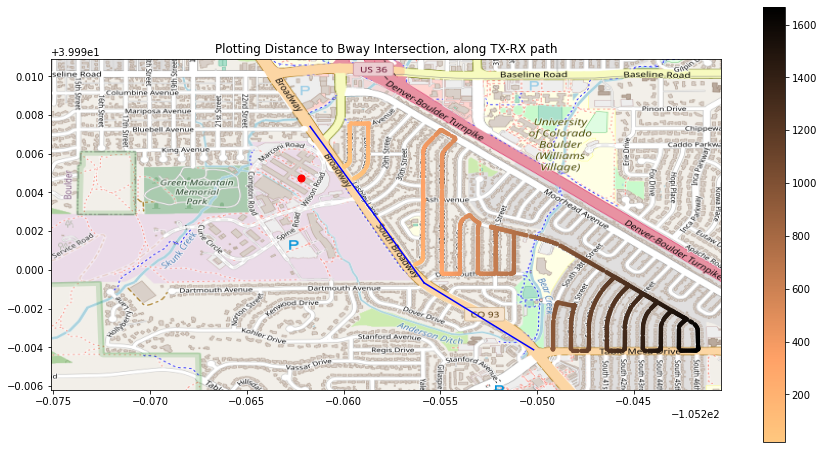

In [33]:
low_long = []
low_lat = []
low_rx_bway_dist = []
for key in low_dict.keys():
    low_long.append(low_dict[key][3])
    low_lat.append(low_dict[key][2])
    d1 = m_intersect( (low_dict[key][0],low_dict[key][1]), (low_dict[key][2],low_dict[key][3]), bway_n, bway_mid)
    d2 = m_intersect( (low_dict[key][0],low_dict[key][1]), (low_dict[key][2],low_dict[key][3]), bway_mid, bway_s)
    low_rx_bway_dist.append(min(d1,d2))

plt.rcParams["figure.figsize"] = (15,8)
ex2 = plt.scatter(low_dict['102'][1],low_dict['102'][0], zorder=2, alpha=1.0, c='r', s=50)
ex1 = plt.scatter(low_long, low_lat, zorder=1, c=low_rx_bway_dist, cmap='copper_r', alpha= 1.0, s=12)
ex3 = plt.plot([bway_n[1],bway_mid[1]], [bway_n[0],bway_mid[0]], zorder=3, alpha=1.0, c='b')
ex4 = plt.plot([bway_mid[1],bway_s[1]], [bway_mid[0],bway_s[0]], zorder=4, alpha=1.0, c='b')

plt.colorbar(ex1)
plt.title('Plotting Distance to Bway Intersection, along TX-RX path')
plt.xlim(BBox[0],BBox[1])
plt.ylim(BBox[2],BBox[3])
plt.imshow(martin_acres, zorder=0, extent = BBox, aspect= 'equal')
plt.show()

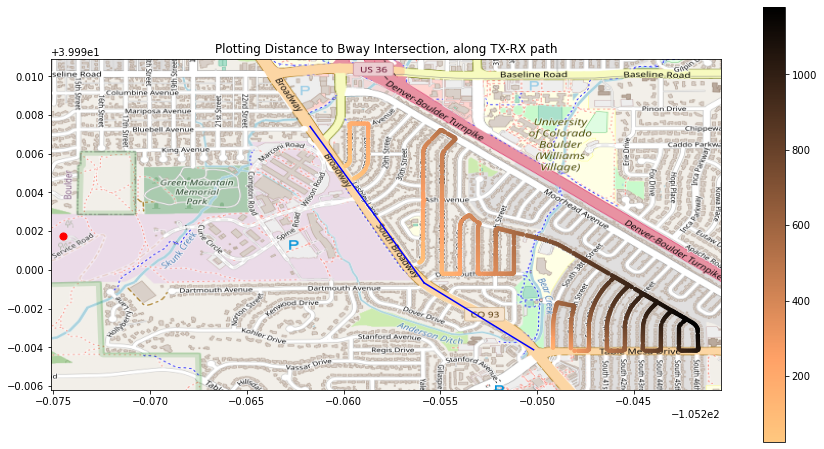

In [34]:
high_long = []
high_lat = []
high_rx_bway_dist = []
for key in high_dict.keys():
    high_long.append(high_dict[key][3])
    high_lat.append(high_dict[key][2])
    d1 = m_intersect( (high_dict[key][0],high_dict[key][1]), (high_dict[key][2],high_dict[key][3]), bway_n, bway_mid)
    d2 = m_intersect( (high_dict[key][0],high_dict[key][1]), (high_dict[key][2],high_dict[key][3]), bway_mid, bway_s)
    high_rx_bway_dist.append(min(d1,d2))

plt.rcParams["figure.figsize"] = (15,8)
ex2 = plt.scatter(high_dict['102'][1],high_dict['102'][0], zorder=2, alpha=1.0, c='r', s=50)
ex1 = plt.scatter(high_long, high_lat, zorder=1, c=high_rx_bway_dist, cmap='copper_r', alpha= 1.0, s=12)
ex3 = plt.plot([bway_n[1],bway_mid[1]], [bway_n[0],bway_mid[0]], zorder=3, alpha=1.0, c='b')
ex4 = plt.plot([bway_mid[1],bway_s[1]], [bway_mid[0],bway_s[0]], zorder=4, alpha=1.0, c='b')

plt.colorbar(ex1)
plt.title('Plotting Distance to Bway Intersection, along TX-RX path')
plt.xlim(BBox[0],BBox[1])
plt.ylim(BBox[2],BBox[3])
plt.imshow(martin_acres, zorder=0, extent = BBox, aspect= 'equal')
plt.show()

In [35]:
print("Martin Acres mean clutter height {:.2f}, and standard deviation {:.2f}".format(np.mean(clutter_heights_ls), np.std(clutter_heights_ls)))

Martin Acres mean clutter height 7.62, and standard deviation 4.34


$L_c = L_{c,m} + Y(p)$ clutter loss is the median clutter loss + the location variability modeled as a log normal distrobution. $p$ is the percentage of locations.

$L_{c,m} = a\text{log}_{10}r_c+b$

$r_c = \text{MIN}(d_c,\frac{h_c}{\text{sin}\theta})$

In [47]:
## loop through low and high data.
##  need access to elevation angle. distance along ray path to broadway. 

## dc is the horizontal distance through clutter

## hc is the representative clutter height
hc = np.mean(clutter_heights_ls) + 2 * np.std(clutter_heights_ls)
## theta is the elevation angle for the direct ray path from RX to TX
hc = 8.71 + 2 * 4.92


In [48]:
temp_dict = low_dict
low_path_length = []
low_elevation_angle = []
low_clutter_loss = []
low_long = []
low_lat = []
low_rx_bway_dist = []
low_rc = []
for key in temp_dict.keys():
    toa = temp_dict[key][11] / (temp_dict[key][7]*1000)
    low_elevation_angle.append(np.arctan(toa)*360/(np.pi*2))
    low_path_length.append(np.sqrt(np.power(temp_dict[key][11],2) + np.power(temp_dict[key][7]*1000,2)))
    low_clutter_loss.append(temp_dict[key][10])
    low_long.append(temp_dict[key][3])
    low_lat.append(temp_dict[key][2])
    d1 = m_intersect( (temp_dict[key][0],temp_dict[key][1]), (temp_dict[key][2],temp_dict[key][3]), bway_n, bway_mid)
    d2 = m_intersect( (temp_dict[key][0],temp_dict[key][1]), (temp_dict[key][2],temp_dict[key][3]), bway_mid, bway_s)
    low_rx_bway_dist.append(min(d1,d2))
    
    dc = min(d1,d2)
    hc_sintheta = hc / (np.sin(np.arctan(toa)))
    low_rc.append(min(dc, hc_sintheta))

In [49]:
temp_dict = high_dict
high_path_length = []
high_elevation_angle = []
high_clutter_loss = []
high_long = []
high_lat = []
high_rx_bway_dist = []
high_rc = []
for key in temp_dict.keys():
    toa = temp_dict[key][12] / (temp_dict[key][7]*1000)
    high_elevation_angle.append(np.arctan(toa)*360/(np.pi*2))
    high_path_length.append(np.sqrt(np.power(temp_dict[key][12],2) + np.power(temp_dict[key][7]*1000,2)))
    high_clutter_loss.append(temp_dict[key][11])
    high_long.append(temp_dict[key][3])
    high_lat.append(temp_dict[key][2])
    d1 = m_intersect( (temp_dict[key][0],temp_dict[key][1]), (temp_dict[key][2],temp_dict[key][3]), bway_n, bway_mid)
    d2 = m_intersect( (temp_dict[key][0],temp_dict[key][1]), (temp_dict[key][2],temp_dict[key][3]), bway_mid, bway_s)
    high_rx_bway_dist.append(min(d1,d2))
    
    dc = min(d1,d2)
    hc_sintheta = hc / (np.sin(np.arctan(toa)))
    # print(dc, hc_sintheta)
    high_rc.append(min(dc, hc_sintheta))

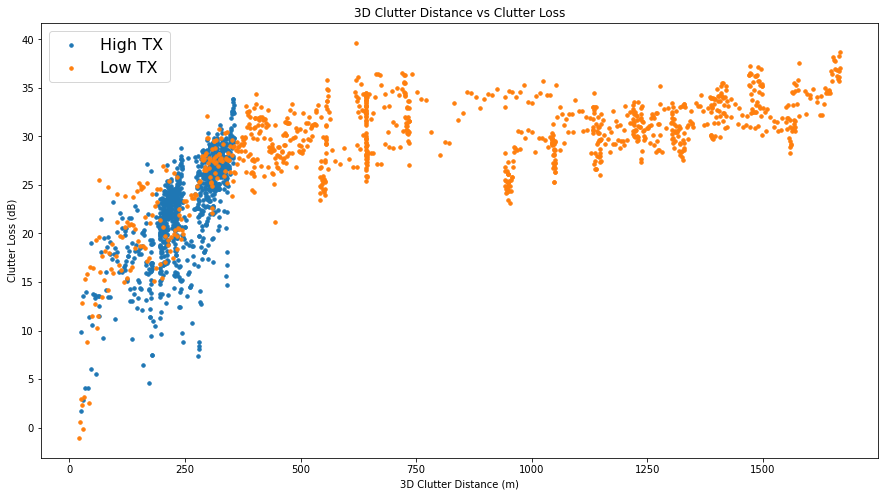

In [50]:
plt.scatter(high_rc, high_clutter_loss, label='High TX', s=12)
plt.scatter(low_rc, low_clutter_loss, label='Low TX', s=12)

plt.xlabel('3D Clutter Distance (m)')
plt.ylabel('Clutter Loss (dB)')
plt.title('3D Clutter Distance vs Clutter Loss')
  
plt.legend(fontsize=16)
plt.show()

In [51]:
full_rc = low_rc + high_rc
full_cl = low_clutter_loss + high_clutter_loss

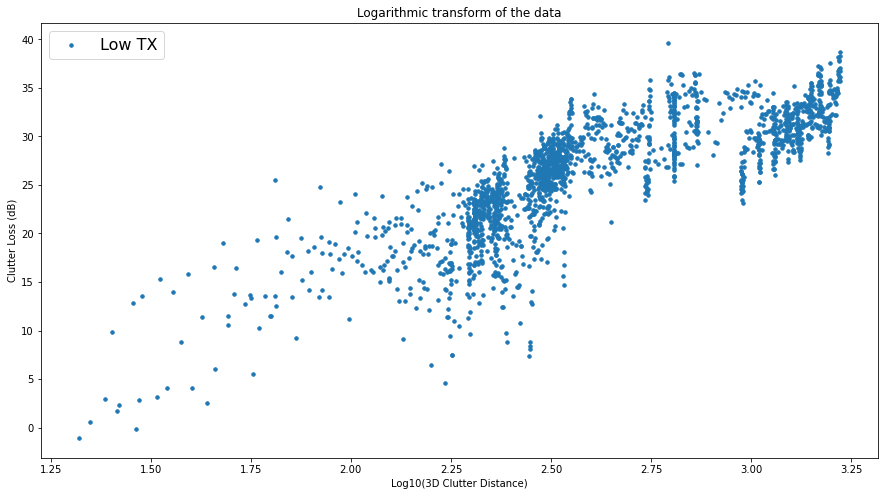

In [52]:
x = np.array(np.log10(full_rc))
y = np.array(full_cl)
plt.scatter(x, y, label='Low TX', s=12)

plt.xlabel('Log10(3D Clutter Distance)')
plt.ylabel('Clutter Loss (dB)')
plt.title('Logarithmic transform of the data')
  
plt.legend(fontsize=16)
plt.show()

In [53]:
linear_regression = LinearRegression()
linear_regression.fit(x.reshape(-1,1), y)
y_int = linear_regression.intercept_
slope = linear_regression.coef_[0]
print("y = {:.2f}log10(x) + {:.2f}".format(slope, y_int))

y = 13.86log10(x) + -10.06


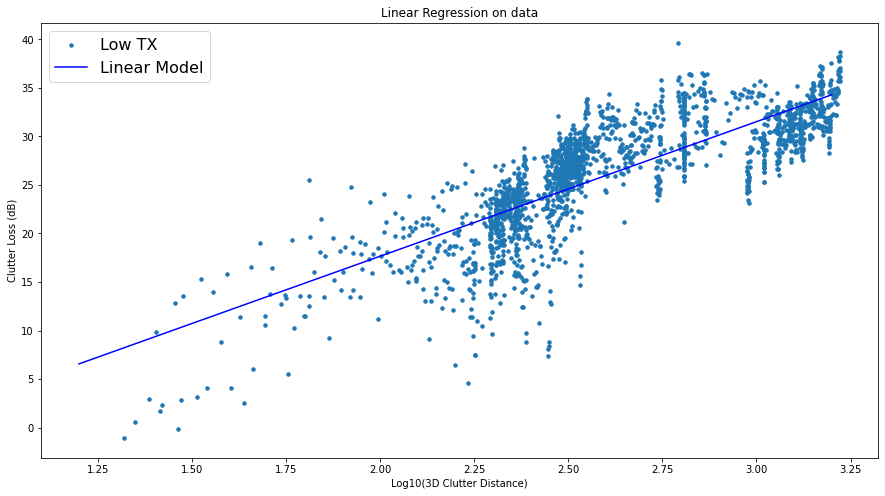

In [54]:
plt.scatter(x, y, label='Low TX', s=12)

z_point = (1.2, slope*1.2 + y_int)
n_point = (3.2, slope*3.2 + y_int)

plt.plot([z_point[0], n_point[0]],[z_point[1], n_point[1]], c='b', label="Linear Model")
plt.xlabel('Log10(3D Clutter Distance)')
plt.ylabel('Clutter Loss (dB)')
plt.title('Linear Regression on data')
  
plt.legend(fontsize=16)
plt.show()

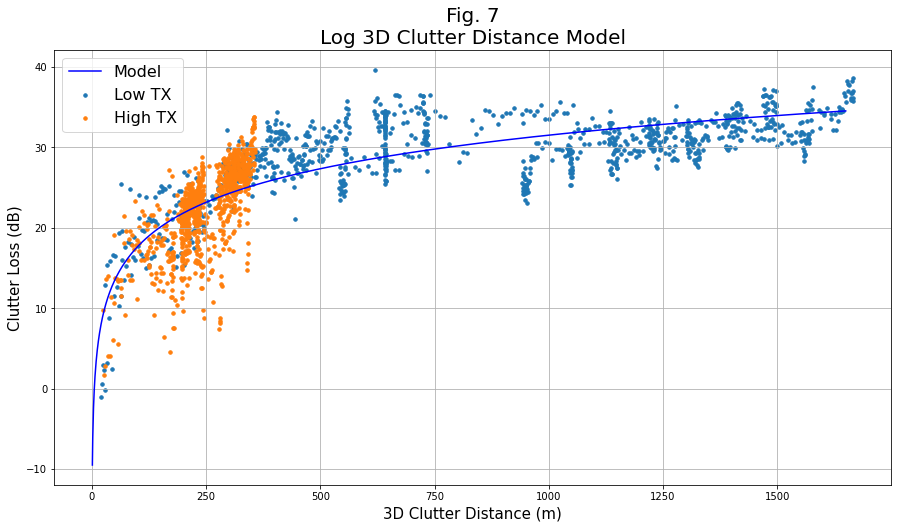

In [55]:
full_x = np.linspace(1.1,1650,2000)
full_y = slope*np.log10(full_x) + y_int
plt.plot(full_x, full_y, label='Model', c='b')
plt.scatter(low_rc, low_clutter_loss, label='Low TX', s=12)
plt.scatter(high_rc, high_clutter_loss, label='High TX', s=12)

plt.xlabel('3D Clutter Distance (m)', fontsize=15)
plt.ylabel('Clutter Loss (dB)', fontsize=15)
plt.title('Fig. 7\nLog 3D Clutter Distance Model', fontsize=20)
plt.grid()
plt.legend(fontsize=16)
plt.show()

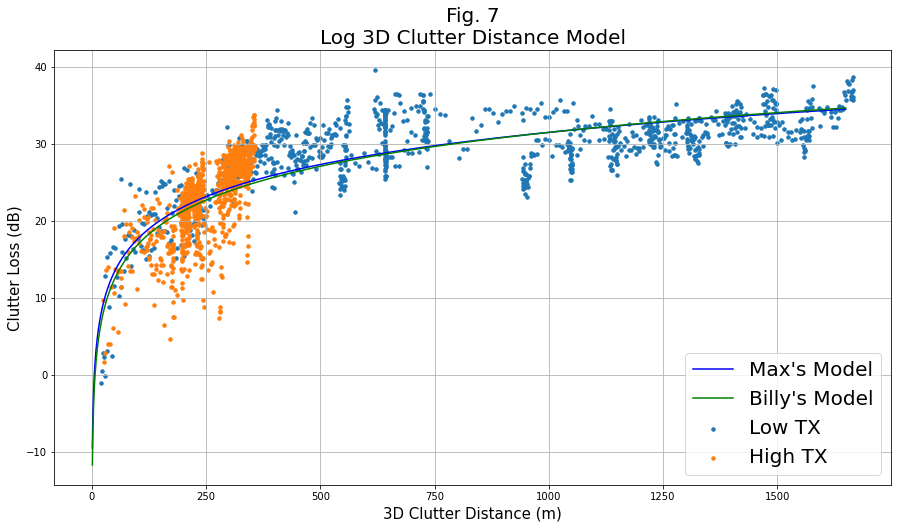

In [56]:
full_x = np.linspace(1.1,1650,2000)
full_y = slope*np.log10(full_x) + y_int
plt.plot(full_x, full_y, label="Max's Model", c='b')

b_y = 14.6*np.log10(full_x) - 12.289
plt.plot(full_x, b_y, label="Billy's Model", c='g')

plt.scatter(low_rc, low_clutter_loss, label='Low TX', s=12)
plt.scatter(high_rc, high_clutter_loss, label='High TX', s=12)

plt.xlabel('3D Clutter Distance (m)', fontsize=15)
plt.ylabel('Clutter Loss (dB)', fontsize=15)
plt.title('Fig. 7\nLog 3D Clutter Distance Model', fontsize=20)
plt.grid()
plt.legend(fontsize=20)
plt.show()

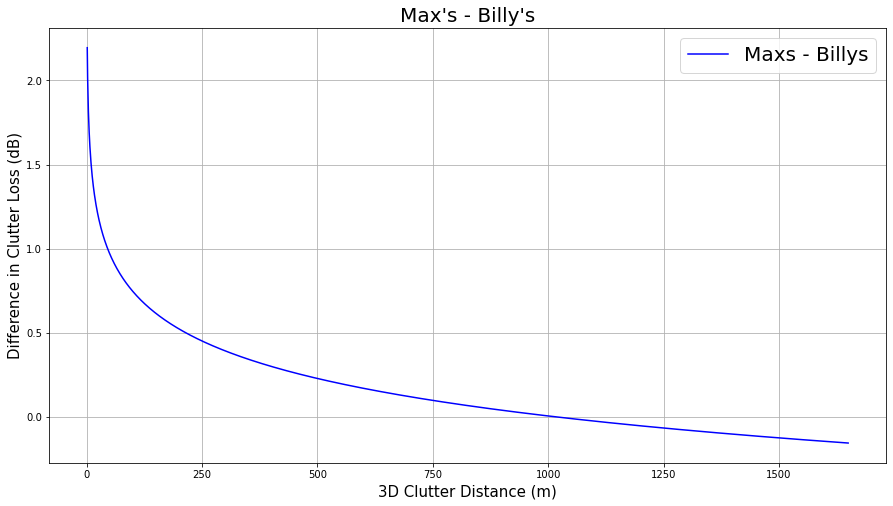

In [57]:
plt.plot(full_x, full_y-b_y, label="Maxs - Billys", c='b')

plt.xlabel('3D Clutter Distance (m)', fontsize=15)
plt.ylabel('Difference in Clutter Loss (dB)', fontsize=15)
plt.title("Max's - Billy's", fontsize=20)
plt.grid()
plt.legend(fontsize=20)
plt.show()

# REQUIREMENTS: Calculation vs Estimation
## Calculation
* Measurements
* Calc. $\mu_c$ Mean Clutter Height, REQUIRES: DTM, DSM, (Lat, Long) of measurement area.
* Calc. $\theta$ RX angle, REQUIRES: DTM, (Lat, Long) of RXs, (Lat, Long) of TX.
* Calc. $d_c$ horizontal distance through clutter, REQUIRES: (Lat, Long) of RXs, (Lat, Long) of TX, (Lat, Long) endpoints of the clutter boundry.
## Estimation
* Measurements
* Estimate $\mu_c$ Mean Clutter Height.
* Calc. $\theta$ RX angle, REQUIRES: DTM, (Lat, Long) of RXs, (Lat, Long) of TX.
* Calc. $d_c$ horizontal distance through clutter, REQUIRES: (Lat, Long) of RXs, (Lat, Long) of TX, (Lat, Long) endpoints of the clutter boundry.


### $y = a \text{log}_{10}(x) + b$
$a$ and $b$ are found through regression with measurements, $\mu_c$, $\theta$s, and $d_c$s.

### Max's $y = 13.4\text{log}_{10}(x) - 8.57$
### Billy's $y = 14.6\text{log}_{10}(x) - 12.289$

How do you find $a$ and $b$ without measurements?

How is frequency factored in?